In [ ]:
import os
import random
import time
from dataclasses import dataclass
import math

from utils import *

import gymnasium as gym
import ale_py
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import tyro
from stable_baselines3.common.atari_wrappers import (
    NoopResetEnv,
    MaxAndSkipEnv,
    FireResetEnv,
    EpisodicLifeEnv,
    ClipRewardEnv
)
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import VecFrameStack
from stable_baselines3.common.buffers import ReplayBuffer
from torch.utils.tensorboard import SummaryWriter

from goal_task import GoalTask

@dataclass
class Args:
    exp_name: str = 'DDQN'
    """the name of this experiment"""
    seed: int = 1
    """seed of the experiment"""
    torch_deterministic: bool = True
    """if toggled, `torch.backends.cudnn.deterministic=False`"""
    cuda: bool = True
    """if toggled, cuda will be enabled by default"""
    track: bool = False
    """if toggled, this experiment will be tracked with Weights and Biases"""
    wandb_project_name: str = "cleanRL"
    """the wandb's project name"""
    wandb_entity: str = None
    """the entity (team) of wandb's project"""
    capture_video: bool = False
    """whether to capture videos of the agent performances (check out `videos` folder)"""
    save_model: bool = False
    """whether to save model into the `runs/{run_name}` folder"""
    upload_model: bool = False
    """whether to upload the saved model to huggingface"""
    hf_entity: str = ""
    """the user or org name of the model repository from the Hugging Face Hub"""

    # Algorithm specific arguments
    env_id: str = "Pong"
    """the id of the environment"""
    total_timesteps: int = int(5e6)
    """total timesteps of the experiments"""
    learning_rate: float = 0.0025
    """the learning rate of the optimizer"""
    num_envs: int = 1
    """the number of parallel game environments"""
    buffer_size: int = int(5e5)
    """the replay memory buffer size"""
    gamma: float = 0.99
    """the discount factor gamma"""
    tau: float = 1.0
    """the target network update rate"""
    target_network_frequency: int = 10000
    """the timesteps it takes to update the target network"""
    batch_size: int = 32
    """the batch size of sample from the reply memory"""
    start_e: float = 1
    """the starting epsilon for exploration"""
    end_e: float = 0.05
    """the ending epsilon for exploration"""
    exploration_fraction: float = 0.5
    """the fraction of `total-timesteps` it takes from start-e to go end-e"""
    learning_starts: int = 20000
    """timestep to start learning"""
    train_frequency: int = 4
    """the frequency of training"""

    # Bayesian linear layer arguments
    noise_var = 1
    prior_var = 0.001
    var_k = 1
    bdqn_learn_frequency = 100000
    target_batch_size = 100000
    state_normalizer = ImageNormalizer()
    reward_normalizer = SignNormalizer()

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def layer_init(layer, w_scale=1.0):
    nn.init.orthogonal_(layer.weight.data)
    layer.weight.data.mul_(w_scale)
    nn.init.constant_(layer.bias.data, 0)
    return layer

def tensor(x):
    if isinstance(x, torch.Tensor):
        return x.to(device = DEVICE)
    x = np.asarray(x, dtype=np.float32)
    x = torch.from_numpy(x).to(DEVICE)
    return x

def to_np(t):
    return t.cpu().detach().numpy()

def reduce_loss(loss, delta=1.0):
    return loss.pow(2).mul(0.5).mean()


# def find_state_rep(args, states, next_states, dones, rewards, actions):
#     config = self.config
#     with torch.no_grad():
#         policy_state_rep = self.network(states)['q']
#         q_next = torch.matmul(self.target_network(next_states)['q'], self.policy_mean.T).detach()
#         q_next = q_next.max(1)[0]
#     q_target = rewards + args.gamma * q_next * (1-dones)
#     return policy_state_rep, q_target

def make_env(env_id, seed, idx, capture_video, run_name):
    def thunk():
        if capture_video and idx == 0:
            env = gym.make(env_id, render_mode="rgb_array")
            env = gym.wrappers.RecordVideo(env, f"videos/{run_name}")
        else:
            env = gym.make(env_id)
        env = gym.wrappers.RecordEpisodeStatistics(env)
        env = NoopResetEnv(env, noop_max=30)
        env = MaxAndSkipEnv(env, skip=4)
        env = EpisodicLifeEnv(env)
        if "FIRE" in env.unwrapped.get_action_meanings():
            env = FireResetEnv(env)
        env = ClipRewardEnv(env)
        env = gym.wrappers.GrayscaleObservation(env)
        env = gym.wrappers.ResizeObservation(env,(84,84))
        env = gym.wrappers.FrameStackObservation(env, 4)
        env.action_space.seed(seed)
        env.observation_space.seed(seed)

        return env

    return thunk


class Actor(nn.Module):
    def __init__(self, env):
        super().__init__()
        self.fc1 = nn.Linear(np.array(env.observation_space.shape).prod(), 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc_mu = nn.Linear(64, np.prod(env.action_space.shape))
        # action rescaling
        self.register_buffer(
            "action_scale", torch.tensor((env.action_space.high - env.action_space.low) / 2.0, dtype=torch.float32)
        )
        self.register_buffer(
            "action_bias", torch.tensor((env.action_space.high + env.action_space.low) / 2.0, dtype=torch.float32)
        )

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = torch.tanh(self.fc_mu(x))
        return x * self.action_scale + self.action_bias


class FeatureNet(nn.Module):
    def __init__(self, env, in_channels, feature_dim=512, prior_var=0.001, noise_var=1.0, var_k=0.001):
        super().__init__()
        self.feature_dim = feature_dim

        self.feature_net = nn.Sequential(
            layer_init(nn.Conv2d(in_channels, 32, kernel_size=8, stride=4)),
            nn.BatchNorm2d(32),
            nn.ReLU(),

            layer_init(nn.Conv2d(32, 64, kernel_size=4, stride=2)),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            layer_init(nn.Conv2d(64, 64, kernel_size=3, stride=1)),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Flatten(),  # to convert [batch, channels, height, width] into [batch, features]
            layer_init(nn.Linear(7 * 7 * 64, feature_dim)),
            nn.ReLU(),

            layer_init(nn.Linear(feature_dim, env.action_space.n))
        )
        
    def update_posterior(self, features, targets, actions):
        device = features.device
        eye = torch.eye(self.feature_dim, device=device)
        
        for a in range(self.num_actions):
            mask = (actions == a)
            if not mask.any():
                continue
            
            phi_a = features[mask]
            y_a = targets[mask].unsqueeze(-1)
            
            # Bayesian update
            precision = phi_a.T @ phi_a / self.noise_var + eye / self.prior_var
            cov = torch.linalg.inv(precision)
            mean = cov @ (phi_a.T @ y_a) / self.noise_var
            
            # Update parameters with numerical stability
            self.policy_mean[a] = mean.squeeze()
            self.policy_cov[a] = cov
            try:
                self.cov_decomp[a] = torch.linalg.cholesky(self.policy_cov[a] + 1e-6 * eye)
            except RuntimeError:
                pass

    def sample_weights(self):
        noise = torch.randn_like(self.policy_mean)
        sampled_weights = self.policy_mean + torch.einsum('aij,aj->ai', 
                                                        self.cov_decomp, noise)
        return sampled_weights

    def forward(self, x):
        return self.feature_net(tensor(x))



def update_target(net, target_net):
    target_net.load_state_dict(net.state_dict())
    target_net.policy_mean.data.copy_(net.policy_mean.data)
    target_net.policy_cov.data.copy_(net.policy_cov.data)
    target_net.cov_decomp.data.copy_(net.cov_decomp.data)



def inference(q_network, args, external_noise=False):
    trajectory = []
    for initial_postion in args.initial_positions:
        inference_env = make_env(args.env_id, args.seed, 0, args.capture_video, run_name, initial_position=initial_postion)()
        obs, _ = inference_env.reset() 
        inference_actor = q_network
        while True:
            with torch.no_grad():
                q_value = q_network(torch.Tensor(obs).to(device))
                action = torch.argmax(q_value).cpu().numpy()
                # if external_noise:
                #      actions += torch.normal(0, actor.action_scale * args.exploration_noise)
                next_obs, reward, termination, truncated, info = inference_env.step(action)
                if termination:
                    break
                obs = next_obs
        trajectory.append(inference_env.get_trajectory())
        inference_env.close()
    return trajectory

def linear_schedule(start_e: float, end_e: float, duration: int, t: int):
    slope = (end_e - start_e) / duration
    return max(slope * t + start_e, end_e)

In [9]:
import stable_baselines3 as sb3


if sb3.__version__ < "2.0":
    raise ValueError(
            """Ongoing migration: run the following command to install the new dependencies:
poetry run pip install "stable_baselines3==2.0.0a1"
"""
        )

args = Args()
run_name = f"{args.env_id}__{args.exp_name}__{args.seed}__{int(time.time())}"
if args.track:
    import wandb

    wandb.init(
        project=args.wandb_project_name,
        entity=args.wandb_entity,
        sync_tensorboard=True,
        config=vars(args),
        name=run_name,
        monitor_gym=True,
        save_code=True,
    )
writer = SummaryWriter(f"runs/{run_name}")
writer.add_text(
    "hyperparameters",
    "|param|value|\n|-|-|\n%s" % ("\n".join([f"|{key}|{value}|" for key, value in vars(args).items()])),
)

# TRY NOT TO MODIFY: seeding

random.seed(args.seed)
np.random.seed(args.seed)
torch.manual_seed(args.seed)
torch.backends.cudnn.deterministic = args.torch_deterministic

device = torch.device("cuda" if torch.cuda.is_available() and args.cuda else "cpu")

In [10]:
# env setup
gym.register_envs(ale_py)
envs = make_env("PongNoFrameskip-v4", args.seed, 0, args.capture_video, run_name)()


q_network = FeatureNet(envs, in_channels=4).to(device)
target_network = FeatureNet(envs, in_channels=4).to(device)
target_network.load_state_dict(q_network.state_dict())

for param in target_network.parameters():
    param.requires_grad = False
    
optimizer = optim.Adam(list(q_network.parameters()), lr=args.learning_rate)


rb = ReplayBuffer(
    args.buffer_size,
    envs.observation_space,
    envs.action_space,
    device,
    optimize_memory_usage= True,
    handle_timeout_termination=False,
)


# Bayesian linear layer logic        
num_actions = envs.action_space.n
noise_var = args.noise_var
prior_var = args.prior_var
var_k = args.var_k
bayes_reg = False

layer_size = 512
sampled_mean = tensor(torch.normal(0, 0.01, size=(num_actions, layer_size)))
policy_mean = tensor(torch.normal(0, 0.01, size=(num_actions, layer_size)))
policy_cov = tensor(torch.normal(0, 1, size=(num_actions, layer_size, layer_size)))
cov_decom = policy_cov #?
for idx in range(num_actions):
    policy_cov[idx] = torch.eye(layer_size)
    cov_decom[idx] = torch.linalg.cholesky((policy_cov[idx] + policy_cov[idx].T)/2.0)
ppt = tensor(torch.zeros(num_actions, layer_size, layer_size))
py = tensor(torch.zeros(num_actions, layer_size))

c:\Users\24401\anaconda3\envs\CBRL\Lib\site-packages\stable_baselines3\common\buffers.py:242: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 14.12GB > 4.21GB
  warnings.warn(


### TRAIN

In [ ]:
obs, _ = envs.reset(seed=args.seed)
all_trajectory = {}
for global_step in range(args.total_timesteps):
    
    # INFERENCE:
    # if global_step % 40000 == 0 or global_step == args.total_timesteps-1:
    #     args.initial_positions = [(2,2), (2,10), (2,18), (10,2), (10,18), (18,2), (18,10), (18,18)]
    #     trajectory = inference(q_network, args)
    #     all_trajectory[f'{global_step}'] = trajectory

    # ALGO LOGIC: put action logic here
    with torch.no_grad():
        q_values = q_network(tensor(args.state_normalizer(obs)).unsqueeze(0))
        action = np.argmax(q_values, axis=-1)[0]
    # TRY NOT TO MODIFY: execute the game and log data.
    next_obs, rewards, terminations, truncations, infos = envs.step(action)

    # TRY NOT TO MODIFY: record rewards for plotting purposes
    if "final_info" in infos or terminations:
        print(f"global_step={global_step}, episodic_return={infos['episode']['r']}")
        writer.add_scalar("charts/episodic_return", infos["episode"]["r"], global_step)
        writer.add_scalar("charts/episodic_length", infos["episode"]["l"], global_step)

    # TRY NOT TO MODIFY: save data to reply buffer; handle `final_observation`
    real_next_obs = next_obs.copy()
    if truncations:
            real_next_obs = infos["final_observation"]
    rb.add(obs, real_next_obs, action, rewards, terminations, infos)

    # TRY NOT TO MODIFY: CRUCIAL step easy to overlook
    if "final_info" in infos or terminations:
        obs,_ = envs.reset()
    else:
        obs = next_obs

    # ALGO LOGIC: training.
    if global_step > args.learning_starts:
        if global_step % args.train_frequency == 0:
            data = rb.sample(args.batch_size)
            with torch.no_grad():
                observations = args.state_normalizer(data.observations)
                next_observations = args.state_normalizer(data.next_observations)
                dones = tensor(data.dones)
                rewards = tensor(data.rewards)
                actions = tensor(data.actions)
                q_next = tensor(target_network(next_observations)).detach()
                best_actions = torch.argmax(q_network(next_observations), dim=-1)
                q_next = q_next.gather(1, best_actions.unsqueeze(1)).squeeze(1)
                q_target = rewards + args.gamma * q_next * (1-dones)
            q = tensor(q_network(observations))
            q = q.gather(1, actions).squeeze(1)
            loss = q_target - q

            if global_step % 100 == 0:
                writer.add_scalar("losses/td_loss", loss.mean().item(), global_step)
                writer.add_scalar("losses/q_values", q.mean().item(), global_step)

            # optimize the model
            loss = reduce_loss(loss)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()   

        # update target network
        if global_step % args.target_network_frequency == 0:
            target_network.load_state_dict(q_network.state_dict())

envs.close()
writer.close()

global_step=816, episodic_return=-21.0
global_step=1789, episodic_return=-20.0
global_step=2544, episodic_return=-21.0
global_step=3361, episodic_return=-21.0
global_step=4123, episodic_return=-21.0
global_step=4938, episodic_return=-21.0
global_step=5753, episodic_return=-21.0
global_step=6667, episodic_return=-20.0
global_step=7485, episodic_return=-21.0
global_step=8301, episodic_return=-21.0
global_step=9056, episodic_return=-21.0
global_step=9811, episodic_return=-21.0
global_step=10724, episodic_return=-20.0
global_step=11481, episodic_return=-21.0
global_step=12299, episodic_return=-21.0
global_step=13209, episodic_return=-20.0
global_step=13964, episodic_return=-21.0
global_step=14781, episodic_return=-21.0
global_step=15755, episodic_return=-20.0
global_step=16667, episodic_return=-20.0
global_step=17484, episodic_return=-21.0
global_step=18239, episodic_return=-21.0
global_step=19001, episodic_return=-21.0
global_step=19978, episodic_return=-20.0
global_step=20733, episodic_r

C:\Users\24401\AppData\Local\Temp\ipykernel_32352\162789578.py:95: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3687.)
  py[int(actions[idx]), :] += policy_state_rep[idx].T * y_target[idx].item()


Posterior updated
Bayesian weights sampled.
global_step=101457, episodic_return=-21.0
Bayesian weights sampled.
global_step=102213, episodic_return=-21.0
Bayesian weights sampled.
global_step=103035, episodic_return=-21.0
Bayesian weights sampled.
global_step=103795, episodic_return=-21.0
Bayesian weights sampled.
global_step=104553, episodic_return=-21.0
Bayesian weights sampled.
global_step=105314, episodic_return=-21.0
Bayesian weights sampled.
global_step=106073, episodic_return=-21.0
Bayesian weights sampled.
global_step=106829, episodic_return=-21.0
Bayesian weights sampled.
global_step=107587, episodic_return=-21.0
Bayesian weights sampled.
global_step=108345, episodic_return=-21.0
Bayesian weights sampled.
global_step=109164, episodic_return=-21.0
Bayesian weights sampled.
global_step=109921, episodic_return=-21.0
Bayesian weights sampled.
global_step=110676, episodic_return=-21.0
Bayesian weights sampled.
global_step=111438, episodic_return=-21.0
Bayesian weights sampled.
glob

KeyError: 'final_observation'

In [64]:
q.gather(1, actions).squeeze(1)

tensor([-0.0510, -0.1796, -0.0515, -0.0510, -0.1646,  0.0298, -0.1502, -0.0510,
        -0.1317, -0.0510, -0.0510, -0.0515, -0.2061,  0.0593, -0.1467, -0.1625,
        -0.0515, -0.2547, -0.0515, -0.0515, -0.0510, -0.0510, -0.0510, -0.0515,
         0.0298, -0.0510, -0.0303, -0.1789,  0.0298, -0.0510, -0.1744, -0.0510],
       device='cuda:0', grad_fn=<SqueezeBackward1>)

C:\Users\24401\AppData\Local\Temp\ipykernel_11248\4003016748.py:19: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


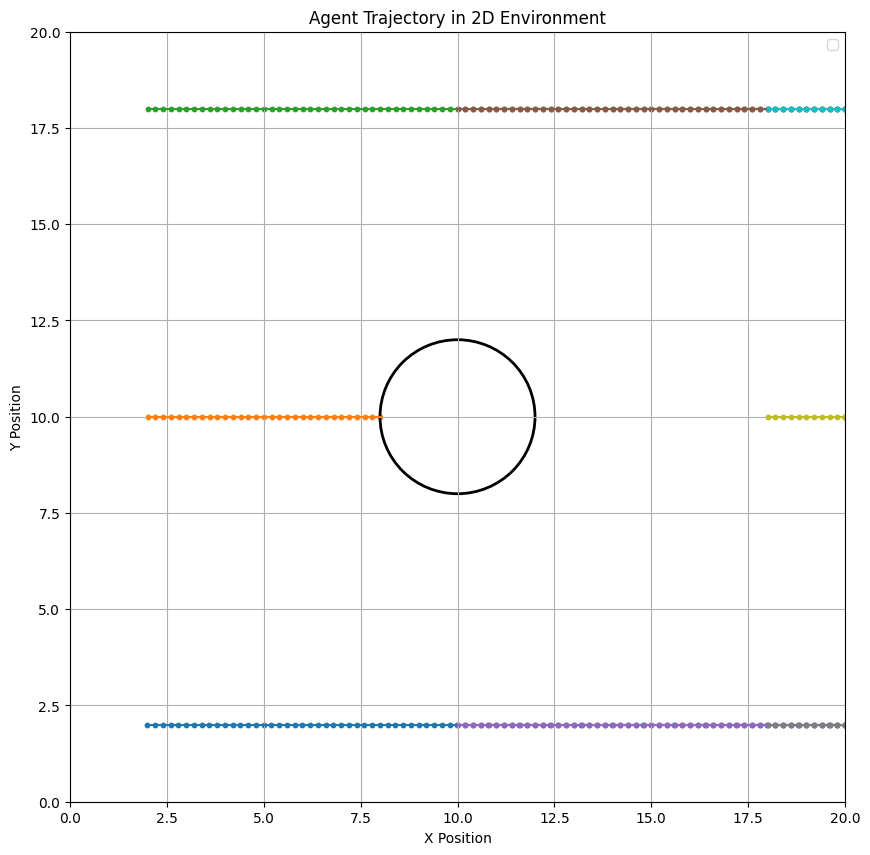

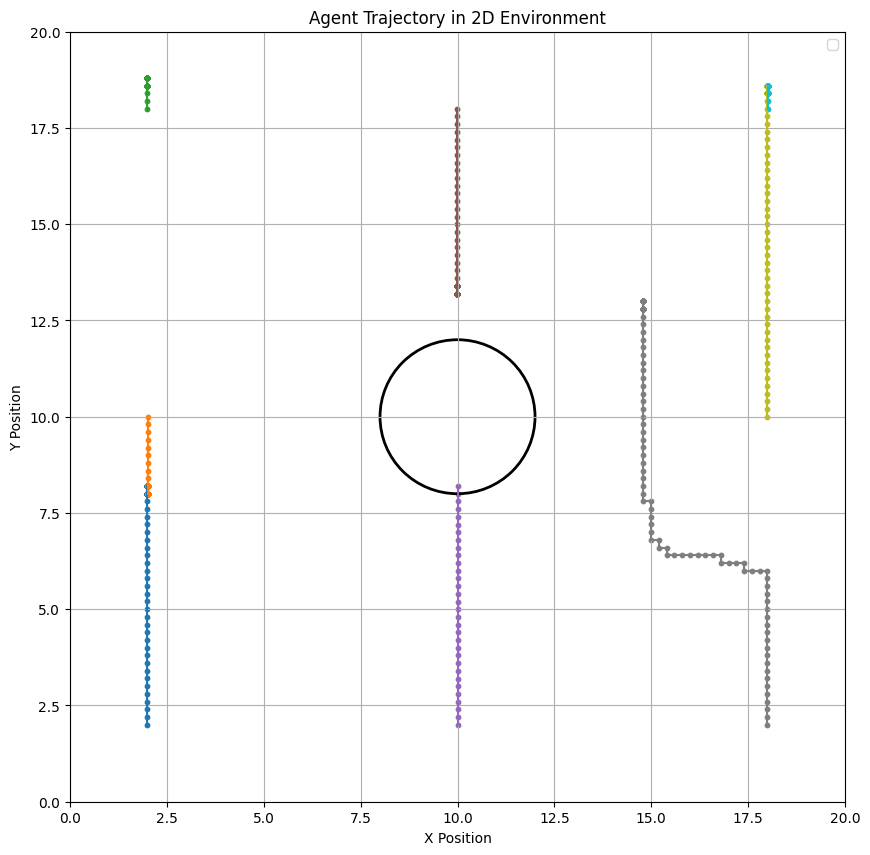

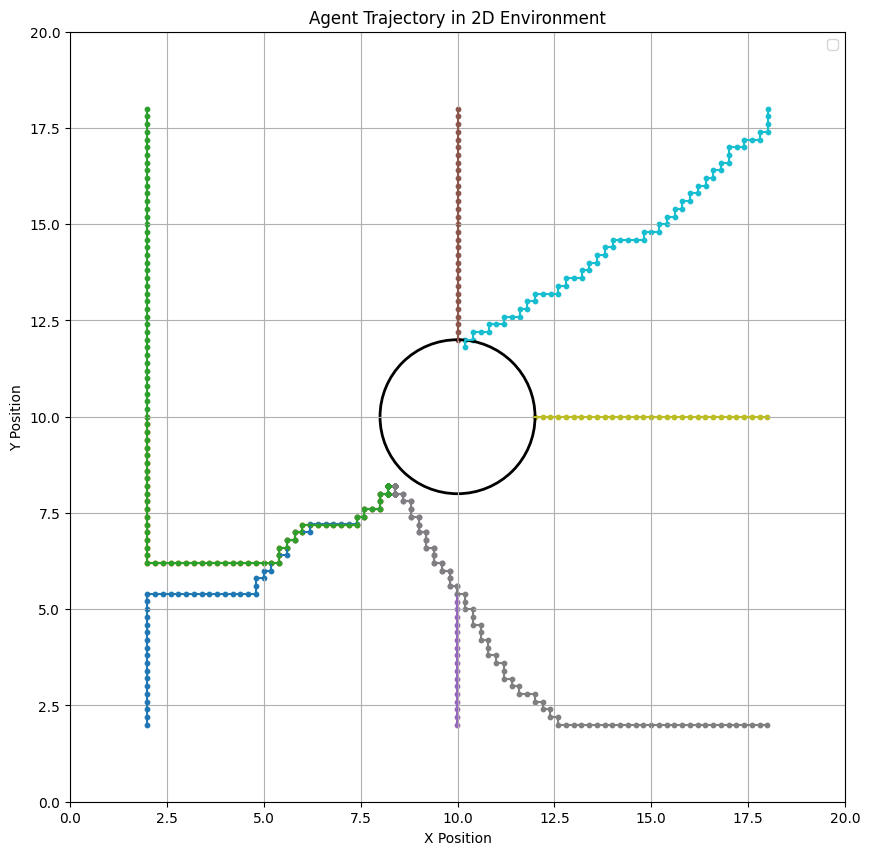

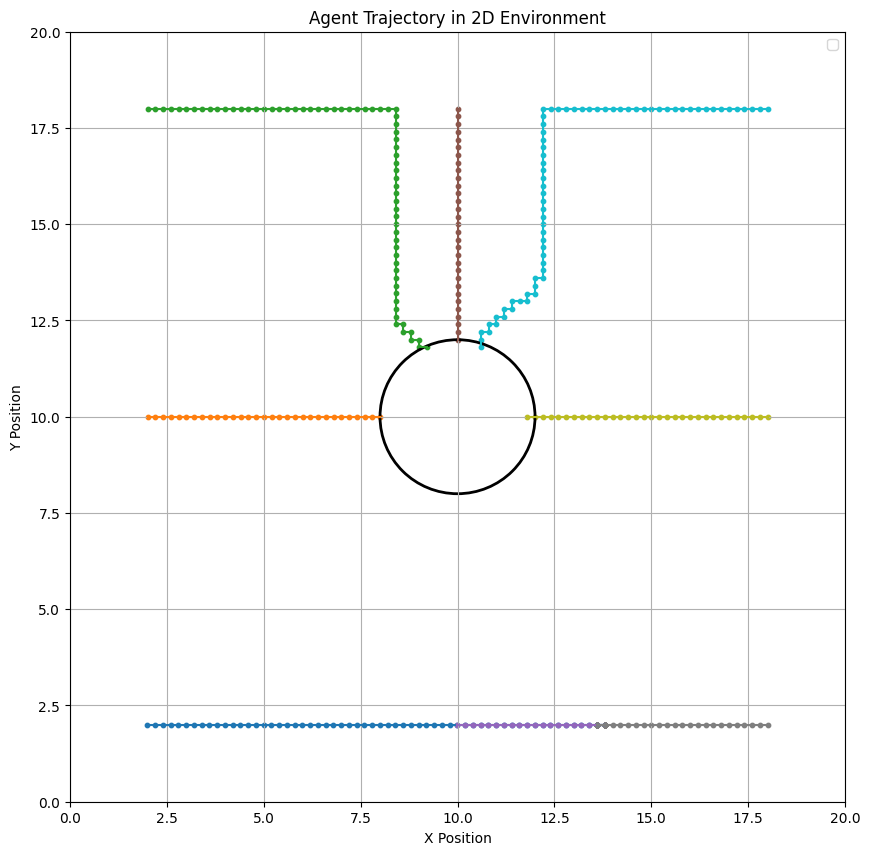

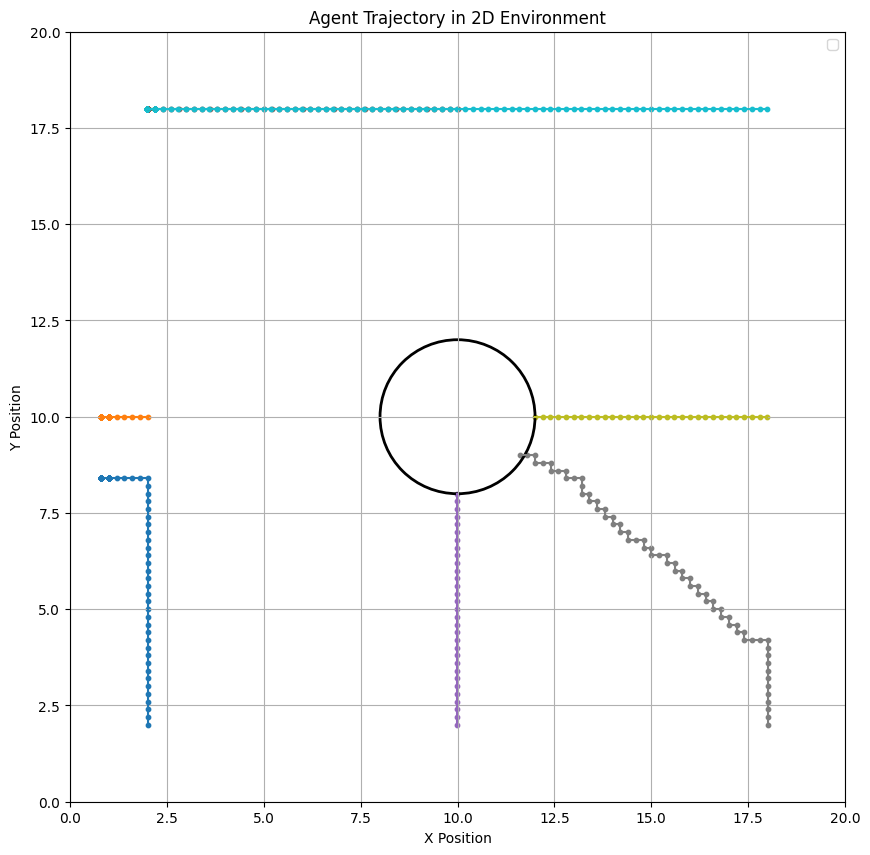

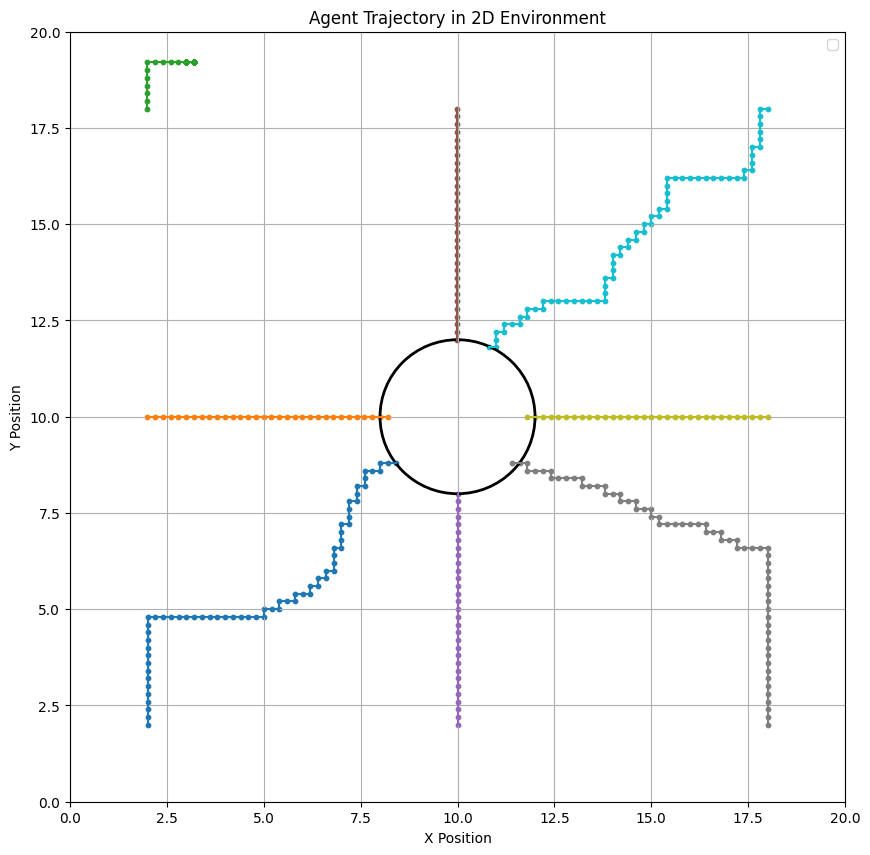

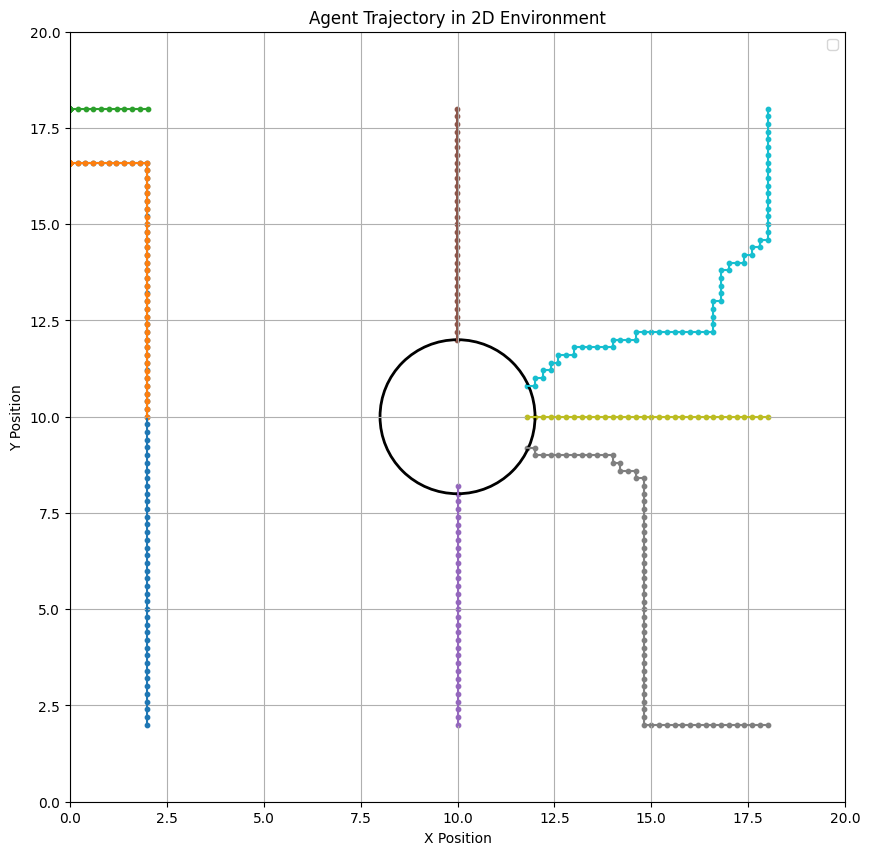

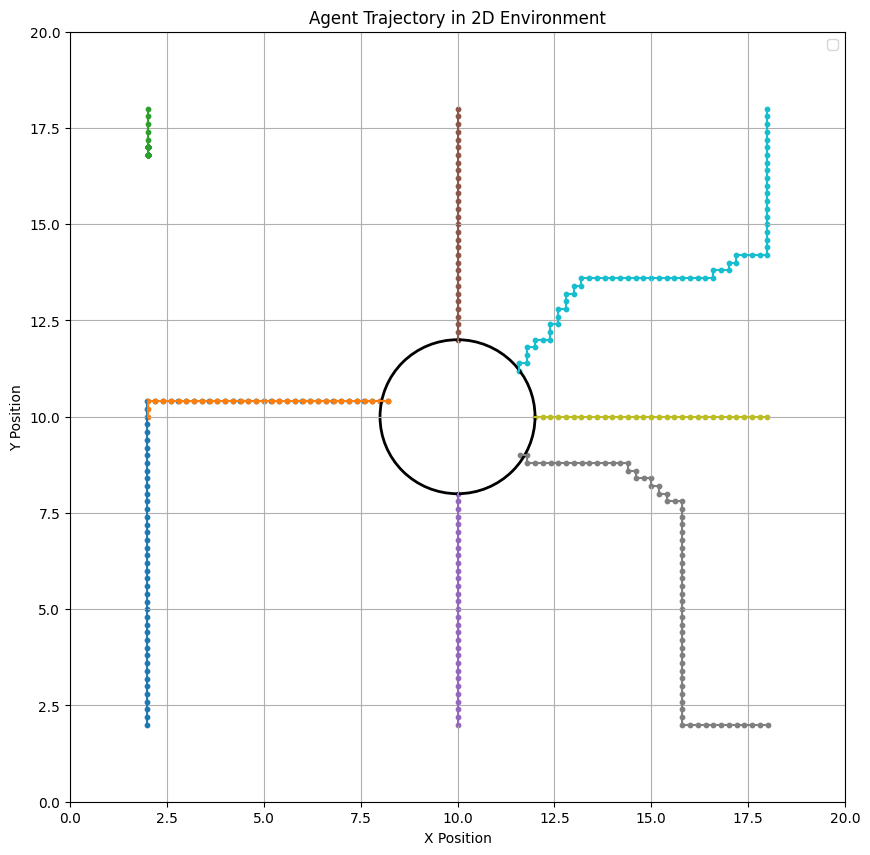

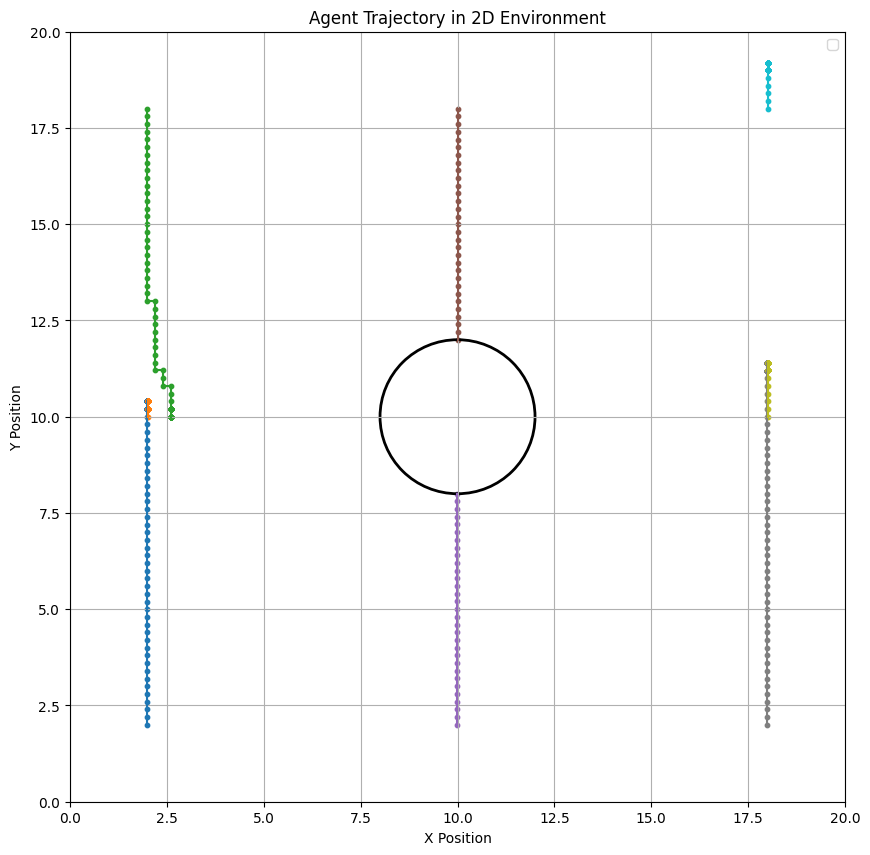

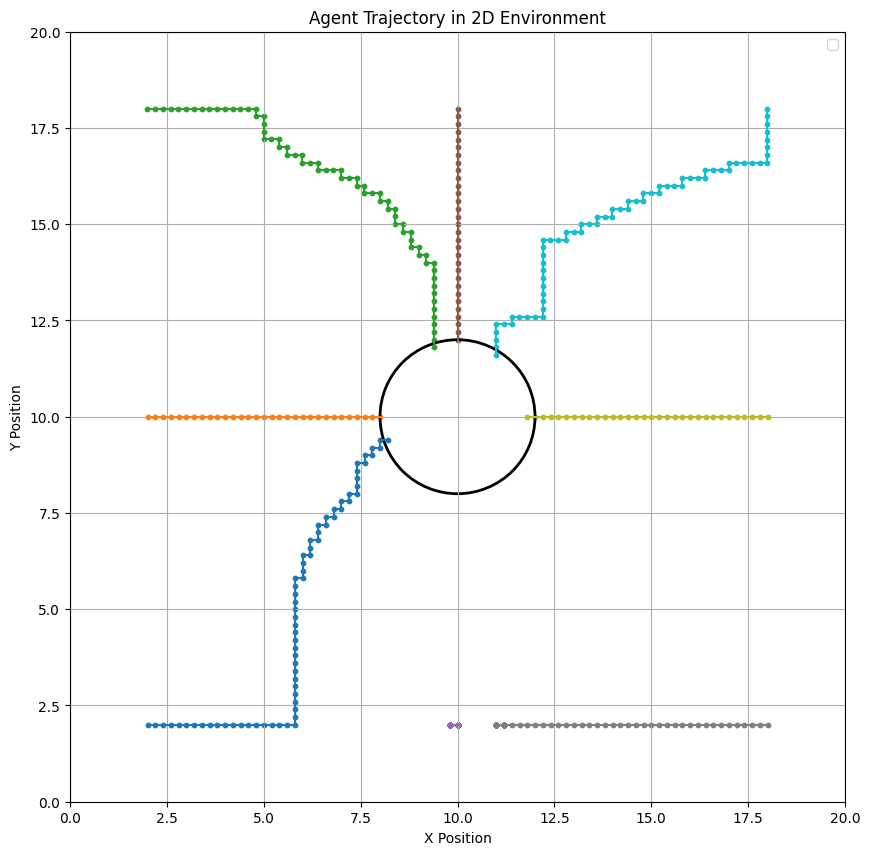

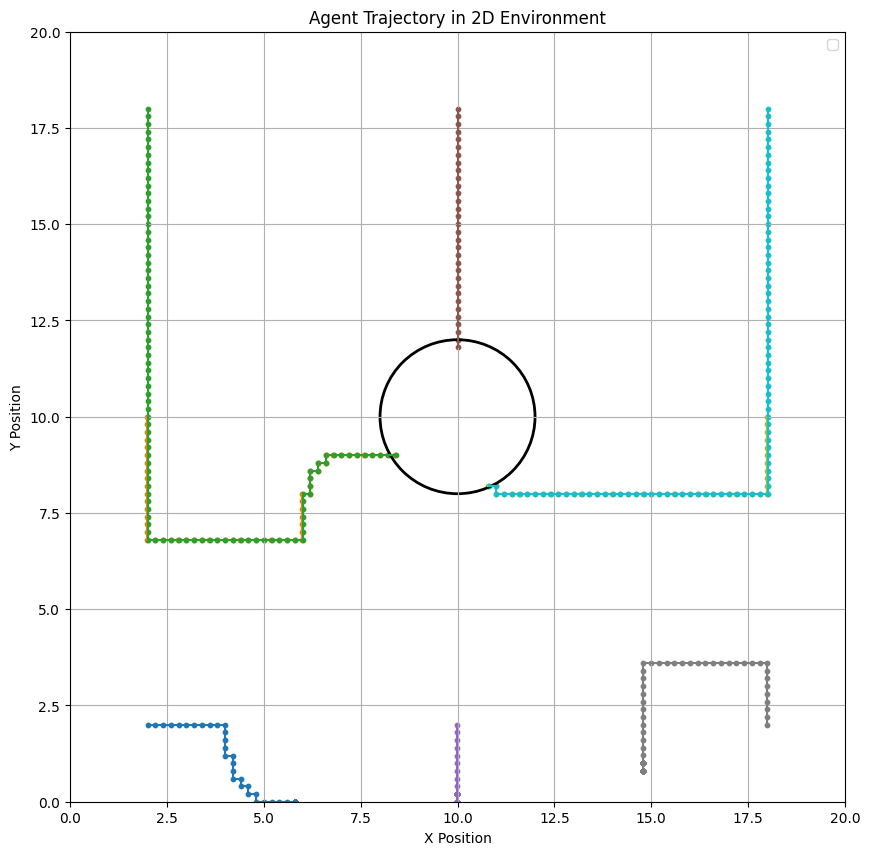

In [10]:
import matplotlib.pyplot as plt
fig_dir = f'runs/{run_name}/figures'
os.makedirs(fig_dir, exist_ok=True)
for trajectories in all_trajectory:
    step = trajectories
    trajectories = all_trajectory[f'{trajectories}']
    fig, ax = plt.subplots(figsize=(10, 10))
    colors = plt.cm.tab10(np.linspace(0, 1, len(trajectories)))
    for i, (trajectory, color) in enumerate(zip(trajectories, colors)):
        ax.plot(trajectory[:, 0], trajectory[:, 1], color=color)
        ax.scatter(trajectory[:, 0], trajectory[:, 1], color=color, s=10)
    circle = plt.Circle((10, 10), radius=2, color='black', fill=False, linestyle='-', linewidth=2)
    ax.add_patch(circle)
    plt.xlim(0, 20)
    plt.ylim(0, 20)
    plt.xlabel('X Position')
    plt.ylabel('Y Position')
    plt.title('Agent Trajectory in 2D Environment')
    plt.legend()
    plt.grid(True)
    plt.savefig(f'{fig_dir}/{step}.png')